## Assignment: Optimization methods

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

## Task

Implement different optimization methods wihout using `autograd` or `torch.optim`. You are only allowed to use pytorch as yur numeric computation framework. The only exception is `visualize` function

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import random
from IPython import display
from sklearn import datasets, preprocessing

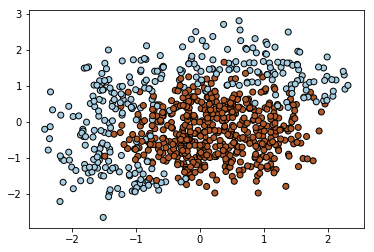

In [2]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = (y==1) | (X[:,1] > X[:,0] - 0.5)

X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
plt.show()

X, y = torch.FloatTensor(X), torch.FloatTensor(y)

In [3]:
import numpy as np

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):    
    plt.clf()
    xy = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    Z = classify(xy, w)
    
    Z = Z.numpy()
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [4]:
def expand(X):
    prod = X[:,0] * X[:,1]
    prod = prod.unsqueeze(1)
    oness = torch.ones_like(X[:, 0])
    oness = oness.unsqueeze(1)
    res = torch.cat([X, X ** 2, prod, oness], dim=1)
    return torch.FloatTensor(res)

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    
    X = expand(X)
    classified = X.mv(w).sign()
    return classified

The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [5]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    
    X = expand(X)
    loss = 1 - y * X.mv(w)
    loss = loss.clamp(min=0, max=np.inf).mean()
    return loss

def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    
    X = expand(X)
    grads = torch.where(1 - y * X.mv(w) > 0, -X.t() * y, torch.zeros_like(X.t()))
    return grads.mean(dim=1)

### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

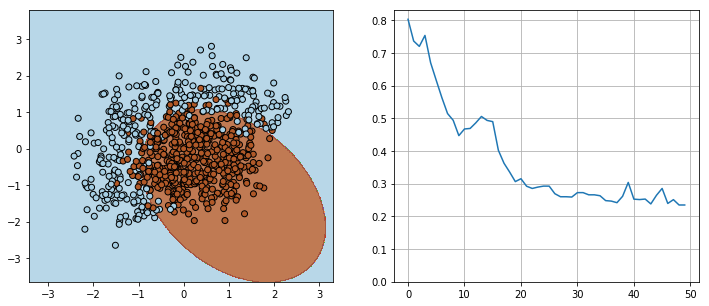

<Figure size 864x360 with 0 Axes>

In [9]:
w = torch.Tensor([1, 0, 0, 0, 0, 0])
alpha = 0.2

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)

    w = w - alpha * compute_grad(X[ind,:], y[ind], w)    

print(w.shape)
visualize(X, y, w, loss, n_iter)
plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

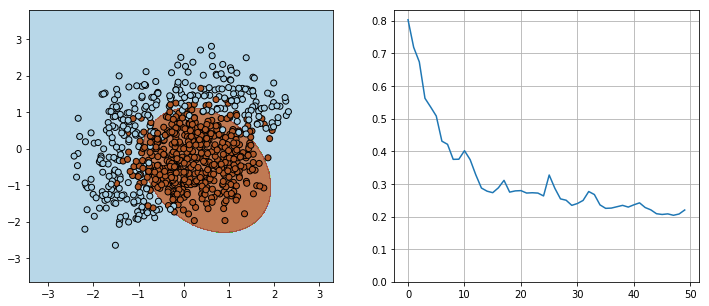

<Figure size 864x360 with 0 Axes>

In [10]:
w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha =  0.2
mu    =  0.5

v = torch.zeros_like(w)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    grads = compute_grad(X[ind,:], y[ind], w)
    v = mu * v - alpha * grads
    w = w + v

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for Nesterov's accelerated gradient:

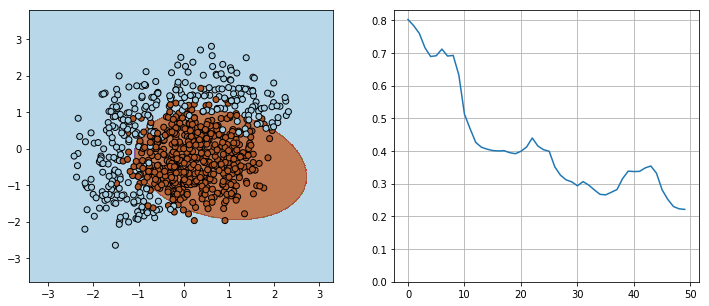

<Figure size 864x360 with 0 Axes>

In [13]:
w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha = 0.1
mu    = 0.5

v = torch.zeros_like(w)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)

    grads = compute_grad(X[ind,:], y[ind], w + mu * v)
    v = mu * v - alpha * grads
    w = w + v

visualize(X, y, w, loss, n_iter)
plt.clf()

Finally, try Adam algorithm. You can start with beta = 0.9 and mu = 0.999

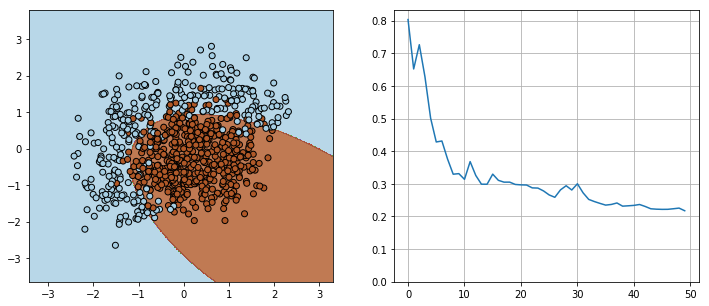

<Figure size 864x360 with 0 Axes>

In [18]:
w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha = 0.14
beta = 0.9
mu = 0.999
eps = 1e-11

v = torch.zeros_like(w)
g = torch.zeros_like(w)


n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    grads = compute_grad(X[ind,:], y[ind], w)
    g = beta * v + (1 - beta) * grads
    v = mu * v + (1 - mu) * grads ** 2
    w = w - alpha / (v.sqrt() + eps) * g

visualize(X, y, w, loss, n_iter)
plt.clf()